In [1]:
%load_ext autoreload
%autoreload 2

from meteo_lib import PROJECT  # または: from meteo_lib.paths import PROJECT
#out_dir  = PROJECT / "outputs"

from meteo_lib.meteo_lib import getBlock, get_HourlyData, get_10minData
from meteo_lib.my_path_utils import DATA, OUT

In [2]:
import pandas as pd
import math
import numpy as np
from datetime import datetime, timedelta, date, time
from metpy.units import units
from metpy.calc import dewpoint_from_relative_humidity
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter, MultipleLocator
import os
from pathlib import Path

In [3]:
# 風向を、float配列に変換する
def ary_int_dd(ary):
    dic = {'北':16,'北北東':1,'北東':2,'東北東':3,
           '東':4,'東南東':5,'南東':6,'南南東':7,
           '南':8,'南南西':9,'南西':10,'西南西':11,
           '西':12,'西北西':13,'北西':14,'北北西':15, '静穏':np.nan}
    awd = np.empty(len(ary),dtype=float)
    for ind in range(len(ary)):
        val = ary.iloc[ind].replace(' )','')
        if val in dic:
            awd[ind] = dic[val]
        else:
            awd[ind] = np.nan
    return awd

def DataConversion(df):

    ns = df.shape[1]
    df['平均風向_dir'] = ary_int_dd(df['平均風向']) * 22.5
    df['最大瞬間時風向_dir'] = ary_int_dd(df['最大瞬間時風向']) * 22.5

    if ns > 7:
        TT = df['気温'].values * units.degC   # 気温
        RH = df['相対湿度'].values * units.percent    # 相対湿度
        Td = dewpoint_from_relative_humidity(TT, RH).to('degC')
        df['露点'] = Td.magnitude

    return df

In [4]:
# 追加：方位 → 角度 の辞書
DIR_TO_DEG = {
    'N': 360, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5, 'E':  90,
    'ESE': 112.5, 'SE': 135, 'SSE': 157.5, 'S': 180,
    'SSE': 202.5, 'SW': 225, 'WSW': 247.5, 'W':  270,
    'WNW':292.5, 'NW': 315, 'NNW': 337.5
}

def range_from_dirs(start_dir: str, end_dir: str):
    """方位文字列から角度範囲を生成"""
    if start_dir not in DIR_TO_DEG or end_dir not in DIR_TO_DEG:
        raise ValueError(f"Invalid direction: {start_dir}, {end_dir}")
    start = DIR_TO_DEG[start_dir]
    end   = DIR_TO_DEG[end_dir]

    # 例えば N→E なら (0, 90)、S→NW なら (180, 315)
    if start <= end:
        return (start, end)
    else:
        # 例: NW → NE (315 → 45) → wrap する場合は360度またぐ
        return (start, end + 360)

In [5]:
# ===== パラメータ =====
FONTSIZE = 14
ROW_HEIGHT = 3  # ★ 1段あたりの高さを固定（ここを変えると全体バランスが変わる）

# ===== 16方位ラベル =====
dirs16 = ['N','NNE','NE','ENE','E','ESE','SE','SSE',
          'S','SSW','SW','WSW','W','WNW','NW','NNW']

def dir_formatter(y, pos):
    val = y % 360
    i = int((val / 22.5) + 0.5) % 16
    return f'{dirs16[i]} '

"""
def dir_formatter(deg, pos):
    d = deg % 360

    # 0°ラベルは消す
    if np.isclose(d, 0.0, atol=1e-6) and deg < 360:
        return ''

    # 360°は N を表示したい
    if np.isclose(deg, 360.0, atol=1e-6):
        return 'N'

    # 通常の方位ラベル
    idx = int(((d / 22.5) + 0.5)) % 16
    return dirs16[idx]
"""

def _first_col(df: pd.DataFrame, candidates: list[str]) -> str | None:
    for c in candidates:
        if c in df.columns:
            return c
    return None

In [6]:
def _unwrap_per_runs(deg_series: pd.Series) -> pd.Series:
    """NaNで分断された連続区間ごとに unwrap する（度→度）。
    入力: 度（0-360想定, NaN含む可）"""
    vals = pd.to_numeric(deg_series, errors='coerce').mod(360).to_numpy(float)
    mask = np.isfinite(vals)
    out = np.full_like(vals, np.nan, dtype=float)

    # NaNの場所で区切るためのランID
    # True/False -> Falseの累積和で「穴」の数を数える
    run_id = (~mask).cumsum()

    # 連続 True 区間ごとに unwrap
    if mask.any():
        for gid in np.unique(run_id[mask]):
            idx = (mask & (run_id == gid))
            rad_seg = np.deg2rad(vals[idx])
            out[idx] = np.rad2deg(np.unwrap(rad_seg))
    return pd.Series(out, index=deg_series.index, dtype=float)

def prepare_wind(df: pd.DataFrame, sel: str) -> pd.DataFrame:

#    sel='JMA'    : 平均風向 + (あれば) 最大瞬間風向 を unwrap。表示列(_disp_*)も付与。
#    sel!='JMA'   : 平均風向のみ unwrap。ガスト系は一切作らない。

    df = df.copy()

    # --- 平均風向の列名（両者で共通に探す） ---
    col_avg = _first_col(df, ["平均風向_dir", "風向_dir", "風向(度)", "風向"])
    if col_avg is None:
        raise KeyError("平均風向の列が見つかりません（例: '平均風向_dir'）。")

    # 平均風向 unwrap
    df["wind_unwrap"] = _unwrap_per_runs(df[col_avg])
    df["_disp_avg"]   = np.mod(df["wind_unwrap"], 360.0)

    if sel == "JMA":
        # JMA のみ “最大瞬間風向” を探す（無ければスキップ）
        col_gust_dir = _first_col(df, ["最大瞬間時風向_dir", "最大瞬間風向_dir", "最大風速風向_dir"])
        if col_gust_dir is not None:
            df["wind_max_unwrap"] = _unwrap_per_runs(pd.to_numeric(df[col_gust_dir], errors="coerce"))
            base = df["wind_unwrap"].to_numpy(float)
            cand = df["wind_max_unwrap"].to_numpy(float)
            with np.errstate(invalid="ignore"):
                aligned = cand + 360.0 * np.round((base - cand) / 360.0)
            df["wind_max_unwrap_aligned"] = aligned
            df["_disp_max"] = np.mod(df["wind_max_unwrap_aligned"], 360.0)
        # gust 列が無ければ何もしない（列自体を作らない）
    # sel!='JMA' は何もしない（平均のみ）

    return df

In [21]:
def style_axis(ax, ylabel=None, fontsize=FONTSIZE, hide_xlabels=False):
    ax.tick_params(axis='both', labelsize=fontsize)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=fontsize)
    if hide_xlabels:
        ax.tick_params(labelbottom=False)
    ax.grid(True, which='both', axis='both', alpha=0.3)


def set_shared_time_axis_all(axes, start, end, fmt='%H:%M', label_interval=2,
                             grid_interval=1, fontsize=FONTSIZE):

#    複数サブプロットの x 軸を完全共通化。
#    - 目盛位置/フォーマッタ/表示範囲は sharex の“親軸”へ一度だけ設定
#    - グリッドとラベルサイズは各軸に適用

    import matplotlib.dates as mdates

    master = axes[-1]  # 一番下を親に（ラベルを表示する軸）
    # --- 共有対象（limits/locators/formatter は sharex で全軸に伝播） ---
    master.set_xlim(start, end)
    master.xaxis.set_major_locator(mdates.HourLocator(interval=label_interval))
    master.xaxis.set_minor_locator(mdates.HourLocator(interval=grid_interval))
    master.xaxis.set_major_formatter(mdates.DateFormatter(fmt))

    # --- 見た目（グリッド/ラベル）は各軸で ---
    for ax in axes:
        # xグリッド（共通のメジャー/マイナーに合わせて描く）
        ax.grid(True, which='major', axis='x', linestyle='-',  linewidth=1.3, alpha=1.0)
        ax.grid(True, which='minor', axis='x', linestyle='--', linewidth=0.8, alpha=0.8)
        # xラベルは親だけ表示
        is_master = (ax is master)
        ax.tick_params(axis='x', labelsize=fontsize, labelbottom=is_master)

def plot_wind_direction(ax, df, sel, fold_to_360=True,
                       dir_range: tuple[str, str] | None=None):

#    dir_range: ('N', 'SE')などの指定があればそれを優先してylimに反映

    df = df[df.index.notna()].copy()

    # 0° を 360° に統一するヘルパ
    def north_to_360(s, tol=1e-3):
#    風向角 s（Series または配列）を 0〜360 に正規化し、
#    0° 付近（±tol）は 360° に寄せる。

        if s is None:
            return None
        # 数値化してコピー
        s = pd.to_numeric(s, errors='coerce').astype(float).copy()
        # 一応 360 の倍数は全部 360 にそろえる
        s = np.mod(s, 360.0)   # 0, 360, 720 ... → 0
#        s[s == 0.0] = 360.0    # 0 → 360 に統一
        # 0° 付近（例えば ±0.001°）を 360° にまとめる
        s[np.isclose(s, 0.0, atol=tol)] = 360.0
        
        return s

    if fold_to_360:
#        y_avg = df["_disp_avg"]
#        y_max = df["_disp_max"] if "_disp_max" in df.columns else None
        y_avg = north_to_360(df["_disp_avg"])
        y_max = north_to_360(df["_disp_max"] if "_disp_max" in df.columns else None)
        
        if dir_range is None:
            # 従来どおり 0〜360 を少しはみ出して表示
            ylim = (-10, 370)
        else:
            # 方位指定に基づいて上書き
            ylim = range_from_dirs(*dir_range)
    else:
        y_avg = df["wind_unwrap"]
        y_max = df["wind_max_unwrap_aligned"] if "wind_max_unwrap_aligned" in df.columns else None

        if dir_range is None: # 指定が無ければ元の計算
            yall = pd.concat([y_avg, y_max]) if y_max is not None else y_avg
            yall = pd.to_numeric(yall, errors='coerce')
            yall = yall[np.isfinite(yall)]
            if len(yall):
                pad = 15.0
                y0 = np.floor((yall.min() - pad) / 22.5) * 22.5
                y1 = np.ceil((yall.max() + pad) / 22.5) * 22.5
                ylim = (y0, y1)
            else:
                ylim = (0, 360)
        else:
            # --- ⬇️ 方位指定に基づく ylim 上書き ---
            ylim_deg = range_from_dirs(*dir_range)
            ylim = ylim_deg

    ax.yaxis.set_major_locator(MultipleLocator(45))
    ax.yaxis.set_minor_locator(MultipleLocator(22.5))
    ax.yaxis.set_major_formatter(FuncFormatter(dir_formatter))

    if sel=='JMA':
        lb='Avg'
    else:
        lb=''
    h = []
    h += ax.plot(df.index, y_avg, linestyle='None', marker='o', 
                 markersize=4, label=f'{lb} Wind Dir')
    if y_max is not None:
        h += ax.plot(df.index, y_max, linestyle='None', color='red',
                     marker='+', markersize=5, label='Max Wind Dir')

    ax.set_ylim(*ylim)
    ax.set_ylabel("Wind direction (°)")

    # 実体がある線だけで凡例
    handles, labels = ax.get_legend_handles_labels()
    non_empty = []
    non_labels = []
    for hd, lb in zip(handles, labels):
        ydata = getattr(hd, "get_ydata", lambda: np.array([]))()
        if np.isfinite(np.asarray(ydata)).any():
            non_empty.append(hd)
            non_labels.append(lb)
    if non_empty:
        ax.legend(non_empty, non_labels)

    ax.grid(True, which='both', axis='y', linestyle='--')


def plot_wind_speed(ax, df, sel, ws_range):
    ws_min, ws_max = ws_range
    ax.set_ylim(ws_min, ws_max)
    if sel=='JMA':
        lb = 'Avg Wind Speed'
    else:
        lb = 'Wind Speed'
    ax.plot(df.index, pd.to_numeric(df['平均風速'], errors='coerce'),
            linestyle='None', marker='o', markersize=4, label=lb)
    if sel == 'JMA' and '最大瞬間風速' in df.columns:
        ax.plot(df.index, pd.to_numeric(df['最大瞬間風速'], errors='coerce'),
                linestyle='None', marker='+', markersize=5, color='red', label='Max Wind Speed')
    ax.legend()
    

def plot_temperature(ax, df, sel, include_dewpoint, select_dew, Temp_range):

    if sel=='JMA':
#        Temp_min, Temp_max = 0, 25    
        Temp_min, Temp_max = Temp_range
        RH_min, RH_max = 30, 100
    else:
        Temp_min, Temp_max = 7.5, 20
        RH_min, RH_max = 30, 100
    
    ax.set_ylim(Temp_min, Temp_max)
    ax.plot(df.index, pd.to_numeric(df['気温'], errors='coerce'), 
            linestyle='None', marker='^', markersize=4,
            color='green', label='Temperature')
    if include_dewpoint and '露点' in df.columns:
        if select_dew==True:
            ax.plot(df.index, pd.to_numeric(df['露点'], errors='coerce'),
                    linestyle='None', marker='v', markersize=4, color='orange',
                    label='Dew Point')
        else:
            ax_RH = ax.twinx()
            ax_RH.plot(df.index, pd.to_numeric(df['相対湿度'], errors='coerce'),
                    linestyle='None', marker='*', markersize=4, color='skyblue',
                    label='Relative Humidity')
            ax_RH.set_ylim(RH_min, RH_max)
            ax_RH.set_ylabel('Relative Humidity (%)', fontsize=FONTSIZE)
            ax_RH.tick_params(axis='y', labelsize=FONTSIZE)  # 目盛ラベルも揃える

    # --- ここで左右のハンドルを結合し、重複ラベルを除去して一つの凡例に ---
        if select_dew==False:
            handles, labels = ax.get_legend_handles_labels()
            if ax_RH is not None:
                h2, l2 = ax_RH.get_legend_handles_labels()
                handles += h2
                labels  += l2

        # ラベル重複を除去（同名ラベルは後勝ち）
            by_label = dict(zip(labels, handles))

        # 外出しで重なり回避
            ax.legend(by_label.values(), by_label.keys(),
                      loc='upper right')

            return ax_RH  # 必要なら呼び出し側で使えるように返す
        else:
            ax.legend()
    
def plot_pressure(ax, df, sel, Press_range):

    if sel=='JMA':
        P_min, P_max = Press_range
#        P_min, P_max = 990, 1031
    else:
        P_min, P_max = 952, 968.1
    ax.set_ylim(P_min, P_max)
    ax.set_yticks(np.arange(P_min, P_max, 5))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.plot(df.index, pd.to_numeric(df['気圧'], errors='coerce'),
            linestyle='None', marker='D', markersize=3, 
            color='purple', label='Local Pressure')
    ax.legend()

def plot_station(df, station_name, sel, 
                 include_pressure=False, 
                 include_dewpoint=False,
                 select_dew=False,
                 start=None, end=None, savepath=None, 
                 dir_range=None, WS_range=None, Temp_range=None,
                 Press_range=None, title_date_text=None):

    # --- start / end を後で指定する形にする ---
    if start is None:
        start = df.index.min()  # あるいはユーザー指定
    if end is None:
        end = df.index.max()

    # --- 日付表記の自動処理 ---
    if title_date_text is None:
        # index から自動生成（※ 1点だけなら日付取得可）
        try:
            dt = pd.to_datetime(df.index[0])
            title_date_text = dt.strftime('%Y.%m.%d')
        except:
            title_date_text = ''

    df = prepare_wind(df, sel)   # ← ここだけで JMA/非JMA の差を吸収

    nrows = 4 if include_pressure else 3
    fig, axes = plt.subplots(
        nrows, 1, figsize=(12, ROW_HEIGHT * nrows),
        tight_layout=True, gridspec_kw={'height_ratios': [1]*nrows}, sharex=True
    )
    if nrows == 1:
        axes = [axes]
    ax_dir, ax_wind, ax_temp = axes[0], axes[1], axes[2]

    plot_wind_direction(ax_dir, df, sel, fold_to_360=True, 
                        dir_range=dir_range)
    style_axis(ax_dir, ylabel='Wind Direction', hide_xlabels=True)

    plot_wind_speed(ax_wind, df, sel, ws_range=WS_range)
    style_axis(ax_wind, ylabel='Wind Speed (m/s)', hide_xlabels=True)

    plot_temperature(ax_temp, df, sel, 
                     include_dewpoint=include_dewpoint,
                     select_dew=select_dew, Temp_range=Temp_range)
    style_axis(ax_temp, ylabel='Temperature (℃)', hide_xlabels=include_pressure)        

    if include_pressure:
        ax_pres = axes[3]
        plot_pressure(ax_pres, df, sel, Press_range=Press_range)
        style_axis(ax_pres, ylabel='Pressure (hPa)')

    set_shared_time_axis_all(axes, start, end, fmt='%H:%M', 
                             label_interval=1, grid_interval=1)    # x軸ラベル間隔
    fig.suptitle(f'{station_name} / {title_date_text}', fontsize=FONTSIZE+2)
    plt.tight_layout(rect=[0, 0.03, 1, 0.99])
    if savepath:
        plt.savefig(savepath)
    plt.show()

In [33]:
# ===== データ取得 =====
sel = 'JMA'
#sel = 'Tohoku'    # 'JMA' or 'Tohoku Univ'

if sel=='JMA':
    year, month, day = 2025, 2, 26    # 対象年月日
    start_hour, end_hour = 6, 21    # 描画範囲（時間指定）
    pref, station = '宮城県', '名取'
    info = getBlock(pref, station)
    print(info)
    prec, block, st_name = info['prec'], info['block'], info["Name_2"]

    df = get_10minData(prec, block, year, month, day)
    df = DataConversion(df)
else:
    year, month, day = 2025, 3, 26    # 日時固定
    start_hour, end_hour = 6, 18     # 描画範囲（時間指定）
    fn2 = DATA / "遠刈田中学校AWS-20250326.csv"
    data2 = pd.read_csv(fn2, usecols=[1, 2, 3, 4, 5, 6], skiprows=1, 
                    names=['日時', '気温', '相対湿度', '気圧', '平均風速', '平均風向_dir'],
                    dtype={'気温':'float32', '相対湿度':'float32',
                           '気圧':'float32', '平均風速':'float32', '平均風向_dir':'float32'},
                    encoding='cp932')
    data2['日時'] = pd.to_datetime(data2['日時'])
    df = data2
    df = df.set_index('日時')
    TT = df['気温'].values * units.degC   # 気温
    RH = df['相対湿度'].values * units.percent    # 相対湿度
    Td = dewpoint_from_relative_humidity(TT, RH).to('degC')
    df['露点'] = Td.magnitude
    st_name = 'Togatta JHS'

outdata = DATA / f"{st_name}_{year}{month:02d}{day:02d}.csv"
outfig = OUT / f"plot250326/{st_name}_{year}{month:02d}{day:02d}.png"

df.sort_index(inplace=True)
df.to_csv(outdata, encoding='shift-jis')

# ===== 作図 =====
# X軸の表示範囲
start = pd.Timestamp(f"{year}-{month}-{day} {start_hour}:00")
end   = pd.Timestamp(f"{year}-{month}-{day} {end_hour}:00")
print(start, '  ', end)

{'prec': 34, 'block': 1464, 'Name_2': 'NATORI', 'Alt': 2.0, 'H_Anemo': 8.2, 'Lat': 38.138, 'Lon': 140.917}
2025-02-26 06:00:00    2025-02-26 21:00:00


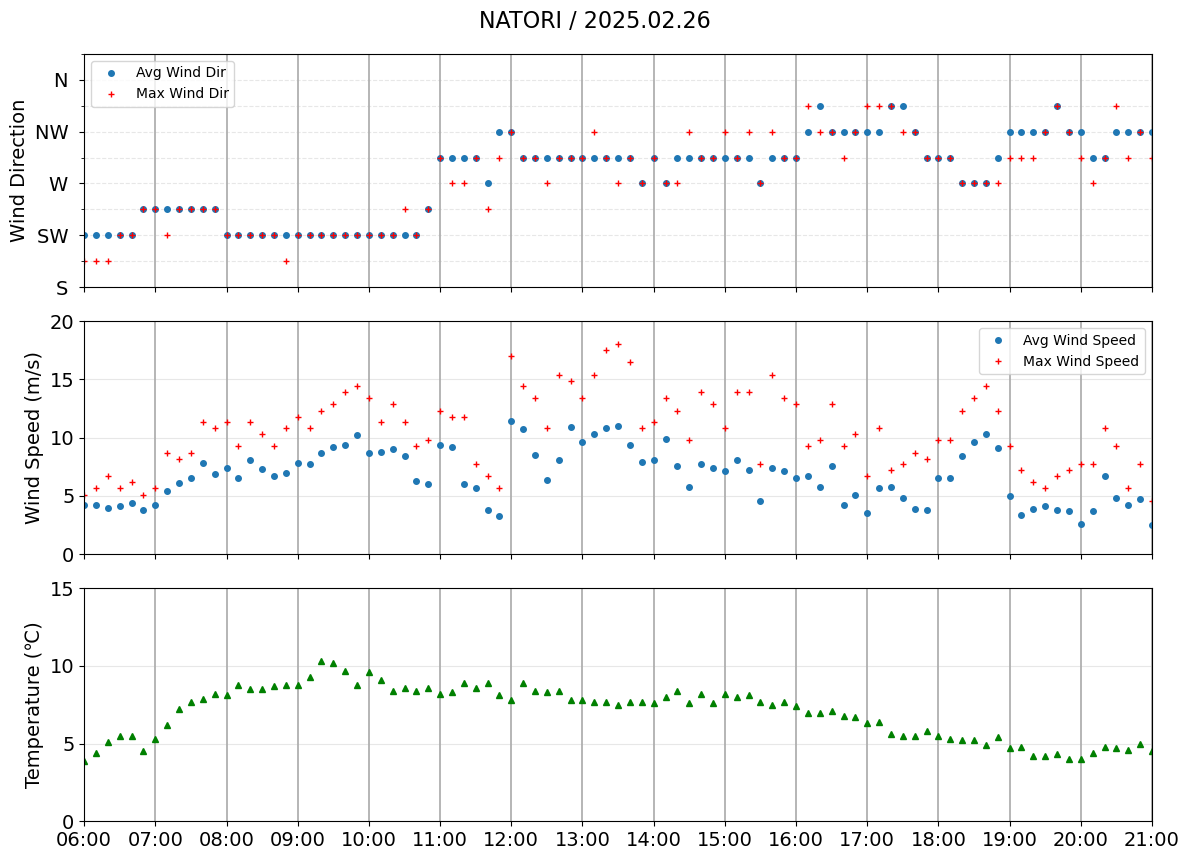

In [36]:
# まず、ケースごとにパラメータを決める
dir_range = None    # 全方位
dir_range = ('S', 'NNE')    # 方位表示範囲
WS_range = (0, 20)    # 風速表示範囲
Temp_range = (0, 15)    # 気温表示範囲
Press_range = (1006,1010)    # 気圧表示範囲

if sel == 'JMA':
    station_label = st_name
    if block > 40000:
        include_pressure  = True
        include_dewpoint  = True
    else:
        include_pressure  = False    # 常にFalse
        include_dewpoint  = False
else:
    station_label     = 'Togatta JHS [Tohoku Univ.]'
    include_pressure  = True
    include_dewpoint  = True
# include_dewpoint がTrueで露点または相対湿度を表示、Falseでどちらも非表示

# 決まったパラメータを使って 1 回だけ呼ぶ
plot_station(
    df.copy(), station_label, sel,
    include_pressure=include_pressure,
    include_dewpoint=include_dewpoint,
    select_dew=True,    
    # select_dew がTrueで露点、Falseで相対湿度を表示(include_dewpoint=Trueの場合) 
    start=start, end=end,
    dir_range=dir_range,
    WS_range=WS_range,
    Temp_range=Temp_range,
    Press_range=Press_range,
    savepath=outfig,
)